In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from PIL import Image # the Python Image Library
from tensorflow import keras
print(np.__version__, tf.__version__)

1.16.4 2.1.0


### Image classification, Part II

In this tutorial, we are going to build on our knowledge about TensorFlow that we have learned in the first tutorial, and learn how to process real-world image data stored in a folder. Since pictures can come with different sizes, we will learn about an import data processing functionality in TensorFlow, `tf.data`, and how to process them to be compatible with our input, and we will also learn a new way to construct a model using the Keras model subclassing API. Let's get started!

#### 1. Data loading with `tf.data`

First, let's download a dataset of pictures of 5 different classes. We can download one such dataset from Google with the `tf.keras.utils.get_file` utility.

In [2]:
data_dir = keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# This dataset folder contains 5 sub-folders corresponding to 5 classes, each containing some images
class_names = np.array([item.name for item in data_dir.glob('*/') if item.name != "LICENSE.txt"])
print(class_names)
print('Total number of images:', len(list(data_dir.glob('*/*.jpg'))))

['dandelion' 'sunflowers' 'tulips' 'roses' 'daisy']
Total number of images: 3670


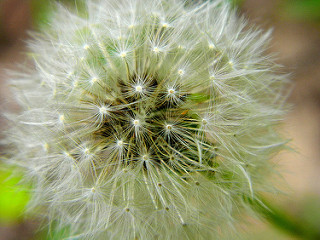

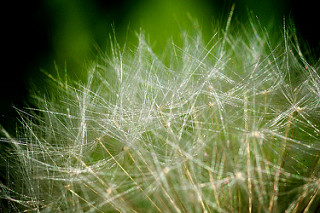

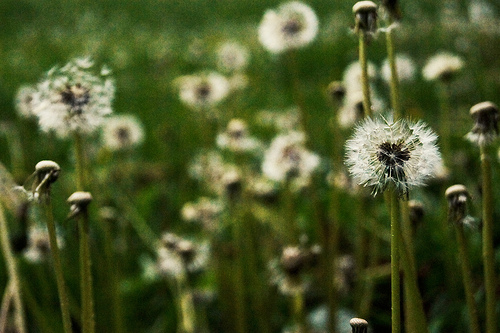

In [3]:
# Let's take a look at a few images from the first class in their original sizes.

for image_path in list(data_dir.glob('dandelion/*.jpg'))[:3]:
    display.display(Image.open(str(image_path)))

We see that the pictures all come in different sizes. Furthermore, they are in the raw JPG format and has to be transformed into some array representation before they can be fed into a neural network as input. One way to do this is to use the `ImageDataGenerator` that we have learned in the last tutorial to create a `ImageDataGenerator` with desired transformations, can call its `flow_from_directory` method to load all images. As arguments of this method, you can define the target width and height of images. However, this is usually slow and lacks fine-grained control. In this tutorial, we are going to learn how to use the `tf.data.Dataset` API to preprocess and load data into a model.

The idea that we are going to follow here is: first, we are going to create a dataset with the file paths of all the pictures; next, we are going to define a series of transformations and apply them to the dataset we created in order to obtain a dataset with images and labels. Let's see this in action.

In [4]:
filepath_dataset = tf.data.Dataset.list_files(str(data_dir/'*/*')) # A dataset created from listing files that have a specific pattern.

# Let's see some example data points in this dataset.
for f in filepath_dataset.take(5): # The `take` method creates a data subset.
    print(f.numpy())

b'/home/sl2678/.keras/datasets/flower_photos/tulips/8717900362_2aa508e9e5.jpg'
b'/home/sl2678/.keras/datasets/flower_photos/roses/18584002386_cec0df537d_n.jpg'
b'/home/sl2678/.keras/datasets/flower_photos/tulips/14087361621_9fefb8dbef.jpg'
b'/home/sl2678/.keras/datasets/flower_photos/sunflowers/210076535_80951bc5d5.jpg'
b'/home/sl2678/.keras/datasets/flower_photos/tulips/4562423077_00b16240dc_n.jpg'


In [5]:
# Let's take 2560 images for training, 512 images for validation and assign the rest as the test set.
train_val_path_dataset = filepath_dataset.take(3072)
train_path_dataset = train_val_path_dataset.take(2560)
val_path_dataset = train_val_path_dataset.skip(2560)
test_path_dataset = filepath_dataset.skip(3072)

In [6]:
# We need to define a transformation function to transform each data point of a file path into a processed image (a 3D tensor) and a label.

def transform_path(file_path):
    # Label can be obtained from the file path.
    # Split the file path into a list of components. The second to last part is the label.
    # The label is one-hot-encoded.
    label = tf.cast(tf.strings.split(file_path, os.path.sep)[-2] == class_names, tf.int32)
    
    # Read the image file.
    img = tf.io.read_file(file_path) # Returns a string tensor.
    
    # Image-related processing functions are located in `tf.image`. 
    # Decode JPG images into 3D uint8 tensors.
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert images to floats in the [0,1) range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize images into a size of 224 × 224 × 3. Note that you only need to specify the desired width and height.
    # If the original image has a different aspect ratio than what you specified, the image will be distorted.
    img = tf.image.resize(img, size=[224, 224])
    
    return img, label

In [7]:
# Now, we apply this transformation function to the file path dataset with the `map` method of the Dataset object.
train_labeled_dataset = train_path_dataset.map(transform_path, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Parallel processing based on available CPUs
val_labeled_dataset = val_path_dataset.map(transform_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_labeled_dataset = test_path_dataset.map(transform_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Let's look at one example in our transformed dataset.
for image, label in train_labeled_dataset.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (224, 224, 3)
Label:  [0 0 1 0 0]


Now that the dataset is in a format that is compatible with a neural network, the last thing we need to do to prepare this data for training is to shuffle it, split it into batches, and optimize speed performance by setting up prefetching, i.e. loading the next batch of data while the network is training. Click <a href="https://www.tensorflow.org/guide/data_performance">here</a> for more information on this.

In [8]:
# Let's define a function to do this. The function should take a Dataset as argument.
def prepare(dataset, batch_size=32, cache=True, train=True, shuffle_buffer_size=1000):
    # If the dataset is small (as in ours), we can keep the entire data in memory.
    if cache:
        dataset = dataset.cache()
        
    if train:
        # Shuffle the training set.
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
        # Repeat the dataset forever so that we can train for multiple epochs.
        dataset = dataset.repeat()
    
    # Split the dataset into batches, so that in each iteration only one batch of data is given to the model.
    # Do this only for the training set because we have a small test set.
    dataset = dataset.batch(batch_size)
    
    # Prefetch batches of data while the model is training.
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # Automatically determine how many batches to prefetch at runtime.
    
    return dataset


# Let's apply these to our image dataset. We are going to use a batch size of 128 and load all data into the cache.
train_dataset = prepare(train_labeled_dataset)
val_dataset = prepare(val_labeled_dataset, batch_size=128, train=False)
test_dataset = prepare(test_labeled_dataset, train=False)

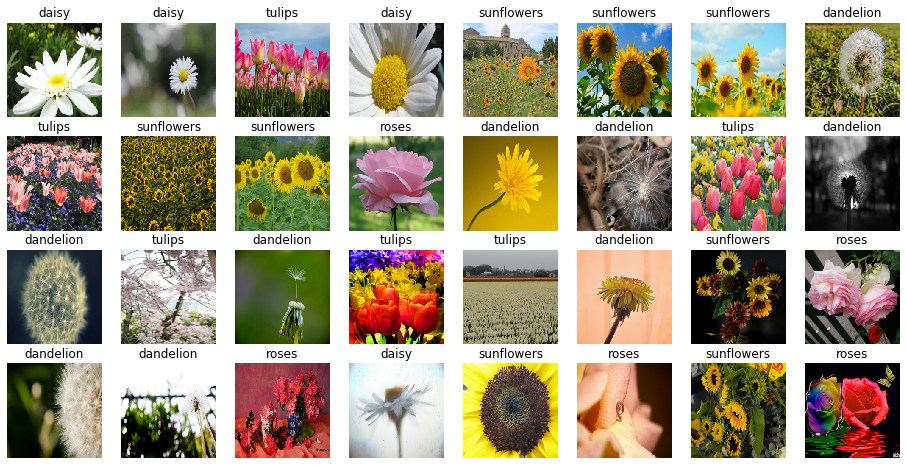

In [9]:
# Take a look at the first batch of data.
# Calling the `__iter__` method of a Dataset creates an iterator, by which we can obtain batches of data.
first_batch_images, first_batch_labels = next(iter(train_dataset))

fig, axes = plt.subplots(4, 8)
fig.set_figwidth(16)
fig.set_figheight(8)

for i in range(32):
    ax = axes[i//8][i%8]
    ax.imshow(first_batch_images[i])
    ax.set_title(class_names[np.where(first_batch_labels[i].numpy() == 1)[0]][0])
    ax.axis('off')

#### 2. Building a neural network with Keras model subclassing

In the last tutorial, we have learned how to build a model using `tf.keras.Sequential`. However, `tf.keras.Sequential` only allows us to build models with linearly stacked layers. We are going to use the Keras subclassing API in order to build more complex model topologies.

The idea of the subclassing API is simple when viewed from an object-oriented perspective. All neural network models are subclasses of a `tf.keras.Model` base class, and we only need to define two things: a constructor (`__init__`) that defines the components of the model, and a `call` method that defines how input is transformed into output using layers in the model. Let's implement a ResNet-like architecture in this tutorial. Since there are shortcut connections in ResNet, it is not a linearly stacked model and is therefore difficult to implement with `tf.keras.Sequential`.

In [10]:
class ResNet(keras.Model):
    
    # The constructor defines model layers.
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.conv1 = keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same', activation='relu')
        self.pool1 = keras.layers.MaxPool2D(pool_size=3, strides=2)
        self.conv2_1 = keras.layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv2_2 = keras.layers.Conv2D(16, kernel_size=3, strides=1, padding='same') # ReLu is applied after shortcut connection.
        self.dimconv1 = keras.layers.Conv2D(32, kernel_size=1, strides=1, padding='valid') # 1-D convolution used to match dimensions.
        self.conv3_1 = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv3_2 = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')
        self.dimconv2 = keras.layers.Conv2D(64, kernel_size=1, strides=1, padding='valid')
        self.conv4_1 = keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv4_2 = keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')
        self.dimconv3 = keras.layers.Conv2D(128, kernel_size=1, strides=1, padding='valid')
        self.conv5_1 = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv5_2 = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')
        self.avgpool = keras.layers.GlobalAveragePooling2D()
        self.dense = keras.layers.Dense(512, activation='relu')
        self.dropout = keras.layers.Dropout(rate=0.5)
        self.out = keras.layers.Dense(num_classes)
        
    # The `call` method defines how input is transformed into the output.
    # Note that `tf.keras.Layers` instances are callable, meaning that input can be given as an argument to obtain the output.
    def call(self, x): # x is our input of shape [None, 224, 224, 3]
        x = self.conv1(x) # Layers are callable
        x = self.pool1(x)
        # This is called the functional API. Each layer can be viewed as a function that transforms input into output.
        # Common activation functions can be accessed in `tf.keras.activations`.
        x = keras.activations.relu(keras.layers.add([self.conv2_2(self.conv2_1(x)), x])) # convx_1 -> ReLU (implemented in layer) -> convx_2 -> shortcut add -> ReLU
        x = keras.activations.relu(keras.layers.add([self.conv3_2(self.conv3_1(x)), self.dimconv1(x)]))
        x = keras.activations.relu(keras.layers.add([self.conv4_2(self.conv4_1(x)), self.dimconv2(x)]))
        x = keras.activations.relu(keras.layers.add([self.conv5_2(self.conv5_1(x)), self.dimconv3(x)]))
        x = self.out(self.dropout(self.dense(self.avgpool(x)))) # AvgPool -> dense -> ReLU (implemented in layer) -> dropout -> output
        return x

In [11]:
# Create a ResNet instance. 
resNetModel = ResNet(5)

# Create a callback to store checkpoints every 2 epochs.
checkpoint_path = './model_checkpoints/tutorial_2/resNet-checkpoint-{epoch:02d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=2)

# Compile our model
resNetModel.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train our model with the created callback. Note that when using tf.data.Dataset as input, we need to specify
# how many iterations to train/validate for each epoch, which is basically dataset size divided by batch size.
# Note how we pass validation data to this `fit` method so that the model is evaluated on the validation set after
# each epoch of training. You can also specify this evaluation to happen only every n epochs using the `validation_freq` argument.
history = resNetModel.fit(train_dataset, epochs=50, steps_per_epoch=2560//32, validation_data=val_dataset, validation_steps=512//128, callbacks=[checkpoint_callback])

W0507 16:47:31.963145 139629553641280 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train for 80 steps, validate for 4 steps
Epoch 1/50
80/80 [==============================] - 71s 892ms/step - loss: 1.4718 - accuracy: 0.3340 - val_loss: 1.3092 - val_accuracy: 0.4355
Epoch 2/50
79/80 [============================>.] - ETA: 0s - loss: 1.2842 - accuracy: 0.4430
Epoch 00002: saving model to ./model_checkpoints/tutorial_2/resNet-checkpoint-02.ckpt
80/80 [==============================] - 70s 872ms/step - loss: 1.2811 - accuracy: 0.4449 - val_loss: 1.1627 - val_accuracy: 0.4824
Epoch 3/50
80/80 [==============================] - 68s 856ms/step - loss: 1.1701 - accuracy: 0.4898 - val_loss: 1.0877 - val_accuracy: 0.5000
Epoch 4/50
79/80 [============================>.] - ETA: 0s - loss: 1.1170 - accuracy: 0.5162
Epoch 00004: saving model to ./model_checkpoints/tutorial_2/resNet-checkpoint-04.ckpt
80/80 [==============================] - 69s 860ms/step - loss: 1.1190 - accuracy: 0.5148 - val_loss: 1.1305 - val_accuracy: 0.5625
Epoch 5/50
80/80 [==============================]

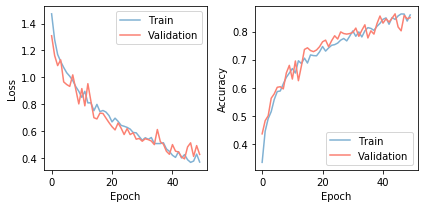

In [12]:
# Let's plot the loss function and accuracy curves for training and validation data.

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)

train_loss = ax1.plot(range(50), history.history['loss'], color='#80b1d3')
val_loss = ax1.plot(range(50), history.history['val_loss'], color='#fb8072')
ax1.legend([train_loss[0], val_loss[0]], ['Train', 'Validation'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

train_acc = ax2.plot(range(50), history.history['accuracy'], color='#80b1d3')
val_acc = ax2.plot(range(50), history.history['val_accuracy'], color='#fb8072')
ax2.legend([train_acc[0], val_acc[0]], ['Train', 'Validation'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')

fig.tight_layout()

We see that the model has been trained well! Both training and validation loss are decreasing, and accuracy is increasing for both sets. It seems like there could still be some improvement if we train for some more epochs. Let's train for another 50 epochs and see what happens.

In [13]:
# You can just call the `fit` method, and the model will continue to train from its last final state.
history_continued = resNetModel.fit(train_dataset, epochs=50, steps_per_epoch=2560//32, validation_data=val_dataset,
                                    validation_steps=512//128, callbacks=[checkpoint_callback])

Train for 80 steps, validate for 4 steps
Epoch 1/50
80/80 [==============================] - 69s 862ms/step - loss: 0.3414 - accuracy: 0.8766 - val_loss: 0.4621 - val_accuracy: 0.8574
Epoch 2/50
79/80 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8813
Epoch 00002: saving model to ./model_checkpoints/tutorial_2/resNet-checkpoint-02.ckpt
80/80 [==============================] - 68s 847ms/step - loss: 0.3118 - accuracy: 0.8820 - val_loss: 0.4409 - val_accuracy: 0.8535
Epoch 3/50
80/80 [==============================] - 66s 830ms/step - loss: 0.3242 - accuracy: 0.8738 - val_loss: 0.5430 - val_accuracy: 0.8086
Epoch 4/50
79/80 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8829
Epoch 00004: saving model to ./model_checkpoints/tutorial_2/resNet-checkpoint-04.ckpt
80/80 [==============================] - 68s 844ms/step - loss: 0.3093 - accuracy: 0.8832 - val_loss: 0.4256 - val_accuracy: 0.8574
Epoch 5/50
80/80 [==============================]

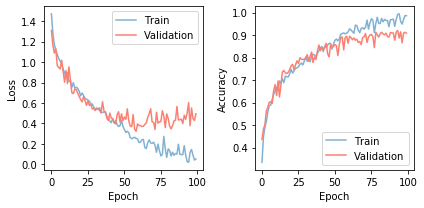

In [14]:
# Let's plot the loss function and accuracy curves all 100 epochs.

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)

train_loss = ax1.plot(range(100), history.history['loss'] + history_continued.history['loss'], color='#80b1d3')
val_loss = ax1.plot(range(100), history.history['val_loss'] + history_continued.history['val_loss'], color='#fb8072')
ax1.legend([train_loss[0], val_loss[0]], ['Train', 'Validation'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

train_acc = ax2.plot(range(100), history.history['accuracy'] + history_continued.history['accuracy'], color='#80b1d3')
val_acc = ax2.plot(range(100), history.history['val_accuracy'] + history_continued.history['val_accuracy'], color='#fb8072')
ax2.legend([train_acc[0], val_acc[0]], ['Train', 'Validation'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')

fig.tight_layout()

We see that although training loss continued to decrease and training accuracy continued to increase, validation loss ceased to decrease at around epoch 70-80, and began to fluctuate. Similarly, validation accuracy stopped increasing and started to fluctuate. This is because overfitting has begun to take place. Therefore, for predictions we may want to use the model trained for only 70-80 epochs. Let's use the checkpoint saved at epoch 82 to restore the model.

In [17]:
resNetModel = ResNet(5)
resNetModel.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Use `resNet-checkpoint-32.ckpt` because checkpoints for the first 50 epochs were replaced by the 
# second training period of 50 epochs.
resNetModel.load_weights('./model_checkpoints/tutorial_2/resNet-checkpoint-32.ckpt')

In [18]:
# Let's test our model on the test set.
resNetModel.evaluate(test_dataset, verbose=2)

19/19 - 3s - loss: 0.3973 - accuracy: 0.9030


[0.39727936469410596, 0.90301]

We can see that test set performance is pretty close to validation set performance. This shows that early stopping is an effective way to mitigate overfitting. In this tutorial we have learned new ways of loading data, processing data. In the next tutorial we are going to move away from image classification, and learn about ways to deal with text data for NLP tasks.